In [1]:
! mkdir -p /root/.pip

In [2]:
%%writefile /root/.pip/pip.conf
[global]
index-url=http://ftp.daumkakao.com/pypi/simple
trusted-host=ftp.daumkakao.com

Overwriting /root/.pip/pip.conf


In [5]:
import time
import datetime
import os
import ast
import sys
import pytz
import random
import shutil
# import splitfolders
import copy
from glob import glob
from tqdm import tqdm
from pprint import pprint

import warnings
import requests

import gc
import math
import numpy as np
import pandas as pd

import cv2
from PIL import Image
# import pydicom as pdm
import pickle
import yaml
import h5py
import json
import matplotlib.pyplot as plt
# import seaborn as sns

import albumentations as albu
import torch
# import torchtuples as tt
from sklearn import metrics

import torchvision
import timm 
# import pretrainedmodels

In [2]:
!pip install albumentations

     |████████████████████████████████| 102 kB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 47.6 MB 17.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [4]:
!pip install timm

     |████████████████████████████████| 376 kB 8.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [6]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
    
print('Using PyTorchversion:', torch.__version__, 'Device:', DEVICE)

Using PyTorchversion: 1.8.0.dev20201207+cu101 Device: cuda


In [7]:
DATA_DIR = '/ainode/dataset/train/'
case_lst = [path.split('/')[-1].split('_')[0] for path in glob(DATA_DIR+'flow/*')]
case_lst.sort()

In [8]:
p_annot_df = pd.read_csv(f'./DATA/annot.csv')
p_annot_df['ID'] = list(range(len(p_annot_df)))
p_annot_df

FileNotFoundError: [Errno 2] No such file or directory: './DATA/annot.csv'

In [8]:
IMG_DIR = '/ainode/dataset/train/'
FLOW_DIR = '/ainode/dataset/train/flow/'
RGB_DIR = '/ainode/dataset/train/rgb/'

In [9]:
p_annot_df['Event_Label'].iloc[1200:2200].value_counts()

Light Sleep    609
Deep Sleep     245
Wake           146
Name: Event_Label, dtype: int64

## Averaging images

In [9]:
!mkdir ./max_images/

mkdir: cannot create directory ‘./max_images/’: File exists


In [10]:
caselst = list(dict.fromkeys(p_annot_df['Case'].tolist()).keys())

In [74]:
# for case in caselst:
#     fps = p_annot_df[p_annot_df['Case'] == case]['FPS'].tolist()[0]
#     img_pth = f'{IMG_DIR}{imgtype[:4]}/{case}_video_01/' 

#     if 'flow' in imgtype:
#         img_lst = glob(img_pth+f'/{imgtype}*.jpg')
#     else:
#         img_lst = glob(img_pth+'/img*.jpg')
#     img_lst.sort()
    
#     for epoch in tqdm(range(int(len(img_lst)/(fps*30)))):
#         img_arr_lst = [np.array(Image.open(img)) for img in img_lst[epoch:epoch+int(fps*30)]]
#         sum_lst = [np.concatenate(img_arr).sum() for img_arr in img_arr_lst]
#         rep_idx = sum_lst.index(max(sum_lst))
#         rep_img = img_arr_lst[rep_idx].astype(np.uint8)
#         print(rep_img.shape)
#         Image.fromarray(rep_img).show()
# #         imave = np.mean(images,axis=0).astype(np.uint8) # (128, 128)
# #         imave = Image.fromarray(imave)
# #         imave.save(f'./max_flow_x/{case}_{epoch+1}.jpg')

In [11]:
case_lst[7]

'A2020-EM-01-0016'

In [ ]:
for case in caselst[15:-2]:
    fps = p_annot_df[p_annot_df['Case'] == case]['FPS'].tolist()[0]
#     img_pth = f'{IMG_DIR}{imgtype[:4]}/{case}_video_01/' 
    flow_pth = f'{IMG_DIR}flow/{case}_video_01/' 
    rgb_pth = f'{RGB_DIR}{case}_video_01/'

#     if 'flow' in imgtype:
#         img_lst = glob(img_pth+f'/{imgtype}*.jpg')
#     else:
#         img_lst = glob(img_pth+'/img*.jpg')
#     img_lst.sort()
    flowx_lst = glob(flow_pth+'flow_x*.jpg')
    flowy_lst = glob(flow_pth+'flow_y*.jpg')
    rgb_lst = glob(rgb_pth+'img*.jpg')
    flowx_lst.sort()
    flowy_lst.sort()
    rgb_lst.sort()
    
    for epoch in tqdm(range(int(len(rgb_lst)/(fps*30)))):
        rgb_arr_lst = [np.array(Image.open(img)) for img in rgb_lst[epoch:epoch+int(fps*30)]]
        flowx_arr_lst = [np.array(Image.open(img)) for img in flowx_lst[epoch:epoch+int(fps*30)]]
        flowy_arr_lst = [np.array(Image.open(img)) for img in flowy_lst[epoch:epoch+int(fps*30)]]
        rgb_sum_lst = [np.concatenate(img_arr).sum() for img_arr in rgb_arr_lst]
        flowx_sum_lst = [np.concatenate(img_arr).sum() for img_arr in flowx_arr_lst]
        flowy_sum_lst = [np.concatenate(img_arr).sum() for img_arr in flowy_arr_lst]
        rgb_rep_idx = rgb_sum_lst.index(max(rgb_sum_lst))
        flowx_rep_idx = flowx_sum_lst.index(max(flowx_sum_lst))
        flowy_rep_idx = flowy_sum_lst.index(max(flowy_sum_lst))
        rgb_rep_img = rgb_arr_lst[rgb_rep_idx].astype(np.uint8)
        rgb_rep_img = np.dot(rgb_rep_img[...,:3], [0.299, 0.587, 0.114])
        flowx_rep_img = flowx_arr_lst[flowx_rep_idx]
        flowy_rep_img = flowy_arr_lst[flowy_rep_idx]
        final_img = (np.dstack((rgb_rep_img,flowx_rep_img,flowy_rep_img))*255).astype(np.uint8)
#         print(final_img.shape)
#         Image.fromarray(final_img).show()
#         print(final_img.shape)
#         imave = np.mean(images,axis=0).astype(np.uint8) # (128, 128)
#         imave = Image.fromarray(imave)
        with open(f'./max_images/{case}_{epoch+1}.npy', 'wb') as f:
            np.save(f, final_img)

 60%|██████    | 479/796 [02:52<01:56,  2.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 97%|█████████▋| 762/788 [04:39<00:09,  2.73it/s]

In [83]:
case #'A2020-EM-01-0027'부터 다시 만들면 됨!

'A2020-EM-01-0027'

In [17]:
case_lst[15]

'A2020-EM-01-0027'

## Train Val Test Split

In [15]:
DATA_NUM = 1000

In [16]:
y = p_annot_df.Event_Label[:DATA_NUM]
X = p_annot_df[['Start_Epoch','Case']][:DATA_NUM]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.1)
len(X_train),len(X_val),len(X_test)

(810, 90, 100)

In [18]:
np.unique(y_train, return_counts=True),\
np.unique(y_val, return_counts=True),\
np.unique(y_test, return_counts=True)

((array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
  array([220, 383, 207])),
 (array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
  array([30, 35, 25])),
 (array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
  array([27, 47, 26])))

## DataLoader

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import sklearn

In [12]:
import torchvision.transforms as transforms

In [137]:
class Dataset(BaseDataset):
    
    def __init__(
            self,  
            X,
            y,
            imgtype, # 'rgb','flow_x','flow_y'
            labels,
            augmentation=None, 
            preprocessing=None,
    ):
        self.epochs = X['Start_Epoch'].tolist()
        self.cases = X['Case'].tolist()
        self.fps = X['FPS'].tolist()
        self.frames = X['Frames'].tolist()
        self.imgpaths = [f'{IMG_DIR}{imgtype[:4]}/{self.cases[idx]}_video_01/' for idx in range(len(self.epochs))]
        self.imgtype = imgtype
        self.labels = labels
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
        le = sklearn.preprocessing.LabelEncoder()
        self.level = le.fit_transform(y.tolist())
    
    def __getitem__(self, i):
        
        # read data
        imgs_path = self.imgpaths[i] # 해당 케이스 이미지 다 들어가있는 디렉토리
        
        if 'flow' in self.imgtype:
            img_lst = glob(imgs_path+f'/{self.imgtype}*.jpg')
        else:
            img_lst = glob(imgs_path+'/img*.jpg')
        img_lst.sort()
        frames = ast.literal_eval(self.frames[i])
        img_lst = img_lst[frames[0]:frames[1]] #img_lst[self.frames[i][0]:self.frames[i][0]+150]
        images = []
        
        for idx, path in enumerate(img_lst):
            if idx % 5 == 0:
#                 image = np.array(Image.open(path).convert('RGB'))
#                 if self.augmentation:
#                     sample = self.augmentation(image=image)
#                     image = sample['image'].convert('RGB')
                image = np.array(Image.open(path).resize((128,128)).convert('RGB'))
                image = np.transpose(image, (2, 0, 1))
                images.append(image)
        
        images = np.array(images)
        images = np.transpose(images, (1,0,2,3))
        images = torch.Tensor(images)
        
        level = torch.as_tensor(self.level[i])

#         if self.preprocessing:
#             sample = self.preprocessing(images = images)
#             images = sample['images']
        
        
        return images, level

        
    def __len__(self):
        return len(self.epochs)

In [138]:
def get_validation_augmentation():
    test_transform = [transforms.Resize((256, 256)), 
    ]
    return albu.Compose(test_transform)


# def to_tensor(x, **kwargs):
#     return x.transpose(3, 0, 1, 2).astype('float32')

In [139]:
def to_tensor(x, **kwargs):
    return x.transpose(3, 0, 1, 2).astype('float32')


def get_preprocessing():
    _transform = [
        albu.Lambda(images=to_tensor),
    ]
    return albu.Compose(_transform)

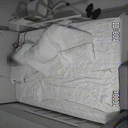

In [140]:
dataset = Dataset(X_train[:5], y_train[:5], 'rgb', ['Wake', 'Light Sleep','Deep Sleep'],)
#                   augmentation = get_validation_augmentation()) #, preprocessing = get_preprocessing())
image, level = dataset[4]

np.array(image).shape
# dataset.cases, dataset.epochs
# np.unique(np.array(images[6]))
# Image.fromarray(np.array(image).astype('uint8'))
Image.fromarray(np.transpose(np.array(image).astype('uint8')[:,0,:,:], (2,1,0)))

In [141]:
BATCH_SIZE = 16

In [193]:
imagetype = 'rgb' # 'rgb', 'flow_x','flow_y'
labels = ['Wake', 'Light Sleep','Deep Sleep']
train_dataset = Dataset(X_train, y_train, imagetype, labels)
val_dataset = Dataset(X_val, y_val, imagetype, labels)
test_dataset = Dataset(X_test, y_test, imagetype, labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset)

In [150]:
print(len(train_loader))

Xtrain, ytrain = next(iter(train_loader))
print('Xtrain:', Xtrain.size(), 'type:', Xtrain.type())
print('ytrain:', ytrain.size(), 'type:', ytrain.type())

print()
print(len(val_loader))

Xval, yval = next(iter(val_loader))
print('Xval:', Xval.size(), 'type:', Xval.type())
print('yval:', yval.size(), 'type:', yval.type())

print()
print(len(test_loader))

Xtest, ytest = next(iter(test_loader))
print('Xtest:', Xtest.size(), 'type:', Xtest.type())
print('ytest:', ytest.size(), 'type:', ytest.type())

51
Xtrain: torch.Size([16, 3, 30, 128, 128]) type: torch.FloatTensor
ytrain: torch.Size([16]) type: torch.LongTensor

6
Xval: torch.Size([16, 3, 30, 128, 128]) type: torch.FloatTensor
yval: torch.Size([16]) type: torch.LongTensor

100
Xtest: torch.Size([1, 3, 30, 128, 128]) type: torch.FloatTensor
ytest: torch.Size([1]) type: torch.LongTensor


In [151]:
%%time
Xtrain, ytrain = next(iter(train_loader))

CPU times: user 0 ns, sys: 153 ms, total: 153 ms
Wall time: 11.7 s


In [152]:
ytrain

tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 2, 2, 0, 1, 1])

In [153]:
pltsize = 4                         

plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(len(Xtrain[:10])):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    img = np.transpose(Xtrain.numpy()[i][:,0,:,:], (2,1,0))[:,:,0]
    plt.imshow(img,cmap="gray_r")
#     plt.title('Class: ' + str(y_train[i].item()))
    plt.title('Class: ' + str(ytrain[i])[-2])

## Train Model

In [154]:
CLASSES = 3

In [155]:
resnet3d = torchvision.models.video.r3d_18(pretrained = True, progress = True)

In [156]:
import torch.nn as nn  

In [157]:
# classifier layer output shape --> number of classes

num_ftrs = resnet3d.fc.in_features
resnet3d.fc = nn.Linear(num_ftrs,CLASSES)
resnet3d.fc = nn.Sequential(resnet3d.fc, nn.Softmax(),)

resnet3d.fc

Sequential(
  (0): Linear(in_features=512, out_features=3, bias=True)
  (1): Softmax(dim=None)
)

In [158]:
LR = 0.00005
EPOCHS = 100
TRAIN_PATIENCE = 10

In [159]:
model = resnet3d.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,
                                verbose=False)

In [160]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [161]:
# https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
# this function is used during training process, to calculation the loss and accuracy

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [162]:
image, label = next(iter(train_loader))
image.shape, label.shape

(torch.Size([16, 3, 30, 128, 128]), torch.Size([16]))

In [163]:
def train(model, train_loader, optimizer, log_interval):
    model.train()                                                 # assign train mode to the model
    
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()                                     # 과거에 이용한 Mini-Batch내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient값이 optimizer에 할당되어 있으므로 optimizer의 Gradient 초기화
        output = model(image)
        loss = criterion(output, label)
        loss.backward()                                           # Back propagation으로 계산된 Gradient 값을 각 parameter에 할당
        optimizer.step()                                          # parameter update
        scheduler.step()
        prediction = output.max(1, keepdim = True)[1]             # predicted labels in tensor
        
        train_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
        train_loss.update(loss.item())
        
        if batch_idx % log_interval == 0:                         # print log
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
    
    total_loss_train.append(train_loss.avg)
    total_acc_train.append(train_acc.avg)

In [164]:
def evaluate(model, test_loader):
    model.eval()
    
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    
    with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            loss = criterion(output, label)
            prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
    
            val_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
            val_loss.update(loss.item())
    
    total_acc_val.append(val_acc.avg)
    total_loss_val.append(val_loss.avg)
    
    return val_loss.avg, val_acc.avg   

In [165]:
best_val_acc = 0
best_val_loss = 100
epoch = 0
total_loss_train, total_acc_train = [],[]
total_loss_val, total_acc_val = [],[]

for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 20)
    val_loss, val_acc = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tVal Loss: {:.4f}, \tVal Accuracy: {:.2f} %\n".format(Epoch, val_loss, val_acc))
    
    # monitoring test accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epoch = Epoch
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, val_loss, val_acc))
        print('*****************************************************')
    elif Epoch > epoch + TRAIN_PATIENCE:
        break
        
#     # monitoring test loss
#     if test_loss < best_val_loss:
#         best_val_loss = test_loss
#         epoch = Epoch
#         print('*****************************************************')
#         print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, test_loss, test_accuracy))
#         print('*****************************************************')
#     elif Epoch > epoch + TRAIN_PATIENCE:
#         break

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/810(0%)]	Train Loss: 1.116505
Train Epoch: 1 [320/810(39%)]	Train Loss: 1.006575
Train Epoch: 1 [640/810(78%)]	Train Loss: 1.018498

[EPOCH: 1], 	Val Loss: 0.8600, 	Val Accuracy: 0.60 %

*****************************************************
best record: [epoch 1], [val loss 0.86004], [val acc 0.60417]
*****************************************************
Train Epoch: 2 [0/810(0%)]	Train Loss: 0.981971
Train Epoch: 2 [320/810(39%)]	Train Loss: 0.809270
Train Epoch: 2 [640/810(78%)]	Train Loss: 0.883600

[EPOCH: 2], 	Val Loss: 0.8496, 	Val Accuracy: 0.70 %

*****************************************************
best record: [epoch 2], [val loss 0.84964], [val acc 0.69792]
*****************************************************
Train Epoch: 3 [0/810(0%)]	Train Loss: 0.933454
Train Epoch: 3 [320/810(39%)]	Train Loss: 0.798805
Train Epoch: 3 [640/810(78%)]	Train Loss: 0.862675

[EPOCH: 3], 	Val Loss: 0.8558, 	Val Accuracy: 0.60 %

Train Epoch: 4 [0/810(0%)]	Train Loss: 0.7913

In [191]:
best_val_acc

0.6979166666666666

# Evaluation

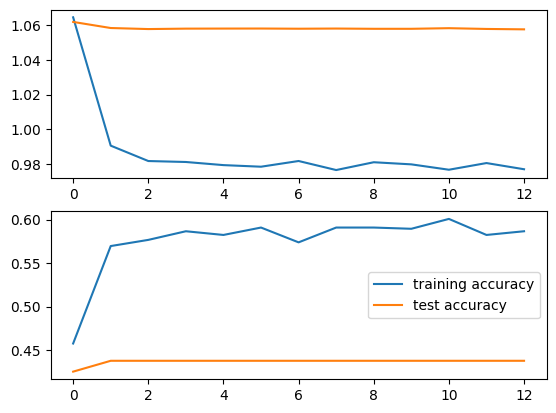

In [205]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_loss_val, label = 'test loss')
fig2.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_acc_val, label = 'test accuracy')
plt.legend()
plt.show()

In [206]:
min(total_loss_val), max(total_acc_val)

(1.0577133297920227, 0.4375)

# Save Model

In [176]:
!mkdir ./saved-models

In [177]:
PATH = "./saved-models/model-epoch{epoch:02d}-loss_val{loss_val:.2f}-acc_val{acc_val:.2f}.pt".format(epoch = epoch, loss_val = total_loss_val[epoch] , acc_val = total_acc_val[epoch])

# torch.save(model.state_dict, PATH)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(), # trained parameters
            'optimizer_state_dict': optimizer.state_dict(), # this contains buffers and parameters that are updated as the model trains
            'accuracy':best_val_acc, #'loss': best_val_loss,
            }, PATH)

In [178]:
resnet3d = torchvision.models.video.r3d_18(pretrained = True, progress = True)

In [179]:
# classifier layer output shape --> number of classes
CLASSES = 3

num_ftrs = resnet3d.fc.in_features
resnet3d.fc = nn.Linear(num_ftrs,CLASSES)
resnet3d.fc = nn.Sequential(resnet3d.fc, nn.Softmax(),)

In [180]:
# best_model = resnet3d.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [183]:
best_model = resnet3d

In [184]:
WORK_DIR = './'

In [187]:
DIR = WORK_DIR + 'saved-models/'

weights = os.listdir(DIR)
weights.sort()
# val_losses = [filename.split('-')[2].split('val')[1] for filename in weights]
val_losses = [filename.split('-')[2].split('val')[1] for filename in weights] #[1:]]
best_weight = val_losses.index(min(val_losses))
# path = './saved_models/' + weights[best_weight]
path = DIR + weights[best_weight] #+1] # '.ipynb_checkpoints' 파일이 맨 앞에 있기 때문에 index가 하나씩 밀린다.

# best_model = torch.load(DIR+'model-epoch00-loss_val1.08-acc_val0.46.pt')
checkpoint = torch.load(path)
best_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
# loss = checkpoint['loss']

best_model.eval()

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

# Inference

In [169]:
!ls /mnt/dataset/test/annotation

A2020-EM-01-0005  A2020-EM-01-0117  A2021-EM-01-0021  A2021-EM-01-0101
A2020-EM-01-0006  A2020-EM-01-0119  A2021-EM-01-0025  A2021-EM-01-0102
A2020-EM-01-0020  A2020-EM-01-0182  A2021-EM-01-0028  A2021-EM-01-0110
A2020-EM-01-0028  A2020-EM-01-0185  A2021-EM-01-0047  A2021-EM-01-0111
A2020-EM-01-0081  A2020-EM-01-0186  A2021-EM-01-0053  A2021-EM-01-0112
A2020-EM-01-0085  A2020-EM-01-0187  A2021-EM-01-0057  A2021-EM-01-0120
A2020-EM-01-0090  A2021-EM-01-0005  A2021-EM-01-0058  A2021-EM-01-0127
A2020-EM-01-0099  A2021-EM-01-0011  A2021-EM-01-0078  A2021-EM-01-0129
A2020-EM-01-0110  A2021-EM-01-0014  A2021-EM-01-0082  A2021-EM-01-0162
A2020-EM-01-0113  A2021-EM-01-0015  A2021-EM-01-0087  A2021-EM-01-0163


In [173]:
!ls /ainode/dataset/test/flow

A2020-EM-01-0005_video_01  A2020-EM-01-0186_video_01  A2021-EM-01-0082_video_01
A2020-EM-01-0006_video_01  A2020-EM-01-0187_video_01  A2021-EM-01-0087_video_01
A2020-EM-01-0020_video_01  A2021-EM-01-0005_video_01  A2021-EM-01-0101_video_01
A2020-EM-01-0028_video_01  A2021-EM-01-0011_video_01  A2021-EM-01-0102_video_01
A2020-EM-01-0081_video_01  A2021-EM-01-0014_video_01  A2021-EM-01-0110_video_01
A2020-EM-01-0085_video_01  A2021-EM-01-0015_video_01  A2021-EM-01-0111_video_01
A2020-EM-01-0090_video_01  A2021-EM-01-0021_video_01  A2021-EM-01-0112_video_01
A2020-EM-01-0099_video_01  A2021-EM-01-0025_video_01  A2021-EM-01-0120_video_01
A2020-EM-01-0110_video_01  A2021-EM-01-0028_video_01  A2021-EM-01-0127_video_01
A2020-EM-01-0113_video_01  A2021-EM-01-0047_video_01  A2021-EM-01-0129_video_01
A2020-EM-01-0117_video_01  A2021-EM-01-0053_video_01  A2021-EM-01-0162_video_01
A2020-EM-01-0119_video_01  A2021-EM-01-0057_video_01  A2021-EM-01-0163_video_01
A2020-EM-01-0182_video_01  A2021-EM-01-0

In [174]:
!ls /ainode/dataset/test/rgb

A2020-EM-01-0005_video_01  A2020-EM-01-0186_video_01  A2021-EM-01-0082_video_01
A2020-EM-01-0006_video_01  A2020-EM-01-0187_video_01  A2021-EM-01-0087_video_01
A2020-EM-01-0020_video_01  A2021-EM-01-0005_video_01  A2021-EM-01-0101_video_01
A2020-EM-01-0028_video_01  A2021-EM-01-0011_video_01  A2021-EM-01-0102_video_01
A2020-EM-01-0081_video_01  A2021-EM-01-0014_video_01  A2021-EM-01-0110_video_01
A2020-EM-01-0085_video_01  A2021-EM-01-0015_video_01  A2021-EM-01-0111_video_01
A2020-EM-01-0090_video_01  A2021-EM-01-0021_video_01  A2021-EM-01-0112_video_01
A2020-EM-01-0099_video_01  A2021-EM-01-0025_video_01  A2021-EM-01-0120_video_01
A2020-EM-01-0110_video_01  A2021-EM-01-0028_video_01  A2021-EM-01-0127_video_01
A2020-EM-01-0113_video_01  A2021-EM-01-0047_video_01  A2021-EM-01-0129_video_01
A2020-EM-01-0117_video_01  A2021-EM-01-0053_video_01  A2021-EM-01-0162_video_01
A2020-EM-01-0119_video_01  A2021-EM-01-0057_video_01  A2021-EM-01-0163_video_01
A2020-EM-01-0182_video_01  A2021-EM-01-0

# Evaluate Model

In [194]:
true_labels = []
predicted_labels = []
predicted_values = []

# best_model.eval()
    
test_loss = AverageMeter()
test_acc = AverageMeter()

with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
    for image, label in test_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = best_model(image)
        loss = criterion(output, label)
        prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
        
        true_labels.append(label)
        predicted_labels.append(prediction)
        predicted_values.append(output)
        
        test_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
        test_loss.update(loss.item())
        
test_loss.avg, test_acc.avg

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
len(predicted_values)

In [190]:
# tensor to array form
true_test_lst = []
predicted_test_lst = []
predicted_value_lst = []

for i in range(len(test_loader)):
    t_labels = true_labels[i].cpu().numpy()
    true_test_lst += list(t_labels)
    
    p_labels = predicted_labels[i].cpu().numpy()[:,0]
    predicted_test_lst += list(p_labels)
    
    p_values = predicted_values[i].cpu().numpy()
    predicted_value_lst += list(p_values)
    
true_test_arr = np.array(true_test_lst)
predicted_test_arr = np.array(predicted_test_lst)
predicted_value_arr = np.array([list(arr) for arr in predicted_value_lst])
    
true_test_arr[:20], predicted_test_arr[:20], predicted_value_arr[:20]

IndexError: list index out of range

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [ ]:
# Confusion Matrix
tick_labels = ['Wake', 'Light Sleep','Deep Sleep']

cm = confusion_matrix(true_test_arr, predicted_test_arr)
ax = sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

In [ ]:
# Classification Report

labels = ['Wake', 'Light Sleep','Deep Sleep']

print(classification_report(true_test_arr, predicted_test_arr, target_names = labels))

In [ ]:
# roc curve for classes

fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(true_test_arr == i, predicted_value_arr[:, i])
    
# plotting
plt.plot(fpr[1], tpr[1], linestyle='--',color='blue', label='Positive: Opacity / Negative: Normal') # Sensitivity: 비정상 중에 비정상으로 predict된 비율 / Specificity: 정상 중에 정상으로 predict된 비율
plt.title('ROC curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='best') 